In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable scrollable cells

<IPython.core.display.Javascript object>

# PyTorch FashionMNIST, MNIST, CIFAR 10

In [0]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow as tf
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()


In [0]:
# taken from here:
# https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/helper.py

def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    elif version == "CIFAR10":
        cifar10_labels = [airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck]
        raise Exception("CIFAR visualization not yet implemented.")
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [5]:
## Required packages
!pip install tensorflow
!pip install scipy
!pip install numpy
!pip install Pillow
!pip install image

## Add any other packages you may need below

In [6]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import time, datetime

from typing import Callable
import dill
import torch.optim as optim
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Ngrok already installed
Tensorboard Link: http://a61724dc.ngrok.io


In [0]:
def train_model(model: nn.Module, 
                log_dir: str,
                train_loader,
                criterion,
                optimizer,
                num_epochs,
               log_freq) -> nn.Module:
    t = datetime.datetime.now()
    now = time.mktime(t.timetuple()) - 1550000000
    logger = Logger(f'{log_dir} ({now})/')
    
    print(now)

    model = model.to(device)

    total_step = len(train_loader)
    for epoch in range(num_epochs):
        running_loss = 0
        for step, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.long().to(device)

            output = model(images).to(device)
            loss = criterion(output, labels).to(device)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute accuracy
            _, argmax = torch.max(output, 1)
            accuracy = (labels == argmax.squeeze()).float().mean()

            running_loss += loss.item()

            if step % log_freq == 0:
                overall_step = epoch*total_step + step

                # 1. Log scalar values (scalar summary)
                info = { 'loss': loss.item(), 'accuracy': accuracy.item() }

                for key, value in info.items():
                    logger.scalar_summary(key, value, overall_step)

                # 2. Log values and gradients of the parameters (histogram summary)
                for key, value in model.named_parameters():
                    key = key.replace('.', '/')
                    logger.histo_summary(key, value.data.cpu().numpy(), overall_step)
                    logger.histo_summary(key+'/grad', value.grad.data.cpu().numpy(), overall_step)

              # 3. Log training images (image summary)
#               info = { 'images': images.view(-1, 28, 28)[:10].cpu().numpy() }

  #             for tag, images in info.items():
  #                 logger.image_summary(tag, images, overall_step)
        print(f"{epoch}: Training loss: {running_loss/len(train_loader)}")
        print(f"{epoch}: Training accuracy: {accuracy}")
 

        
    return model

In [0]:
def test_model(model, criterion, test_loader) -> tuple:
    model = model.to(device)
    correct = 0
    total = 0
    accuracies = []
    losses = []
    total_step = len(test_loader)
    with torch.no_grad():
        for i in range(total_step):
            for  images, labels in test_loader:
                images, labels = images.to(device), labels.long().to(device)

                output = model(images)
                loss = criterion(output, labels)
                losses.append(loss.item())


                # Compute accuracy
                _, argmax = torch.max(output, 1)
                accuracy = (labels == argmax.squeeze()).float().mean()
                accuracies.append(accuracy)

    return (np.average(accuracy.cpu()), np.average(losses))

In [0]:
# Define a transform to normalize the data

batch_size = 100
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.FashionMNIST(root='./data/', 
                                   train=True, 
                                   download=True, 
                                   transform = transform)

test_dataset = torchvision.datasets.FashionMNIST(root='./data/', 
                                   train=False, 
                                   download=True, 
                                   transform = transform)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True);

train_images size: 60000
test_images size: 10000


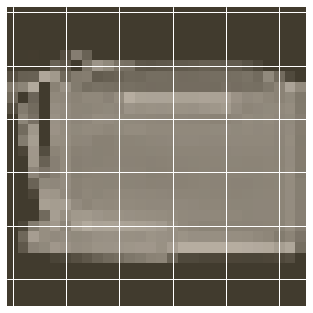

In [0]:
print(f'train_images size: {len(train_loader)*batch_size}')
print(f'test_images size: {len(test_loader)*batch_size}')
image, label = next(iter(test_loader))
imshow(image[0,:]);

In [0]:
class FashionMNIST_NN(nn.Module):
    def __init__(self):
        super(FashionMNIST_NN, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU())
        self.fc4 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU())
        self.fc5 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU())
        self.fc6 = nn.Sequential(
            nn.Linear(64, 10),
            nn.ReLU())
        self.softmax = F.log_softmax

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        out = self.softmax(self.fc6(out), dim=1)
        return out
    


In [0]:
net = FashionMNIST_NN().to(device)
criterion = nn.NLLLoss().to(device)
learning_rate = 0.0012
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
num_epochs = 1
log_freq=25

log_dir = f'./logs/Fashion_MNIST_UPDATED_lr={learning_rate}'
net = train_model(net,
                log_dir,
                train_loader,
                criterion,
                optimizer,
                num_epochs, log_freq)

final_acc, final_loss = test_model(net, criterion, test_loader)
print(f'Average accuracy of the network on test images: {final_acc}')
print(f'Avg. Loss of the network on test images: {final_loss}')

final_acc, final_loss = test_model(net, criterion, train_loader)
print(f'Average accuracy of the network on train images: {final_acc}')
print(f'Avg. Loss of the network on train images: {final_loss}')

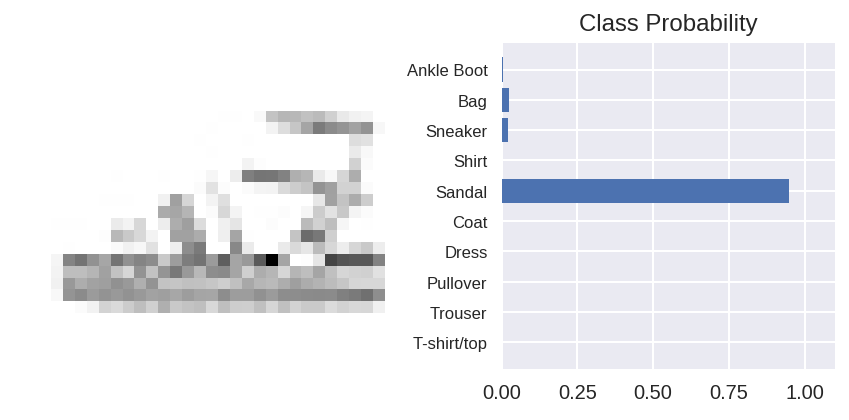

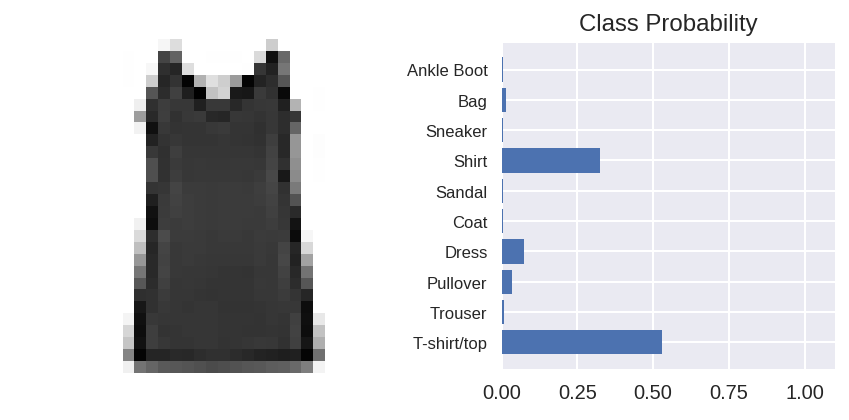

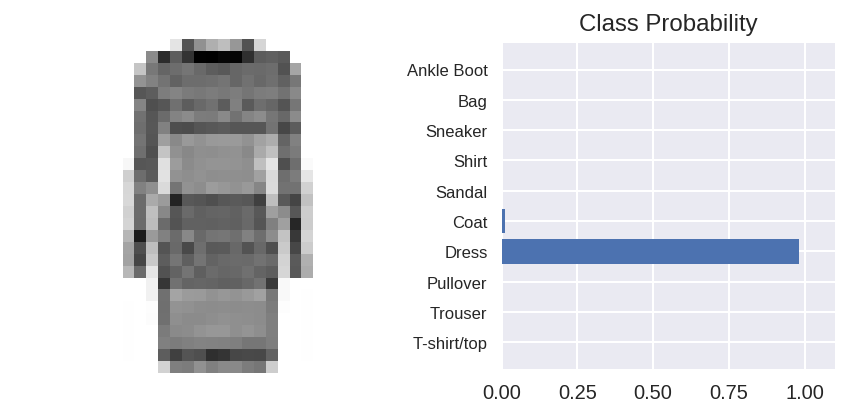

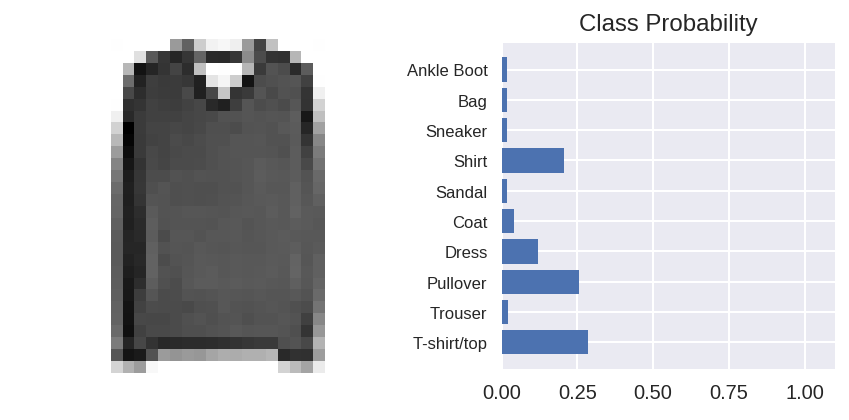

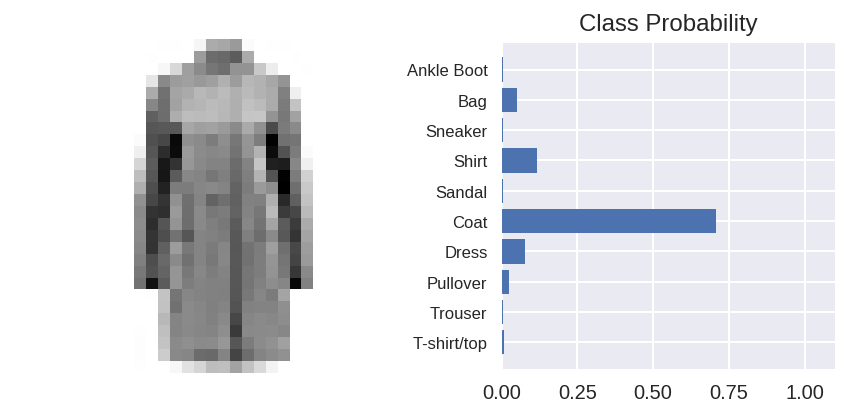

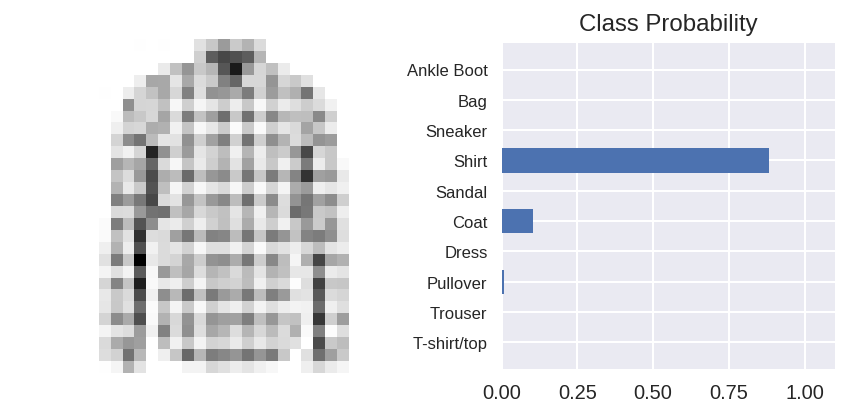

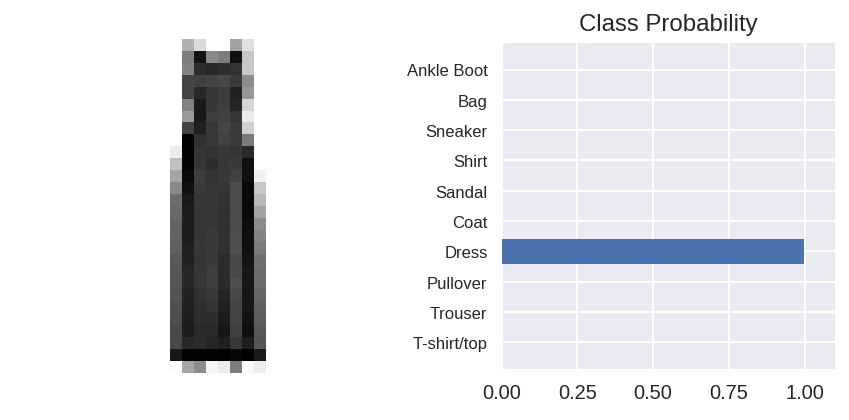

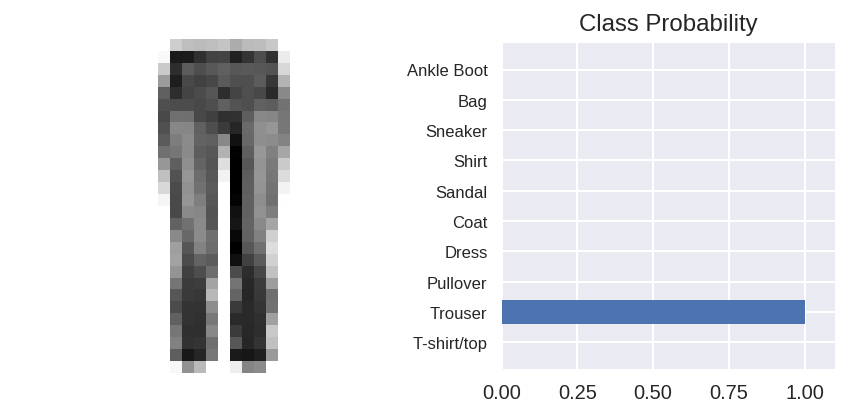

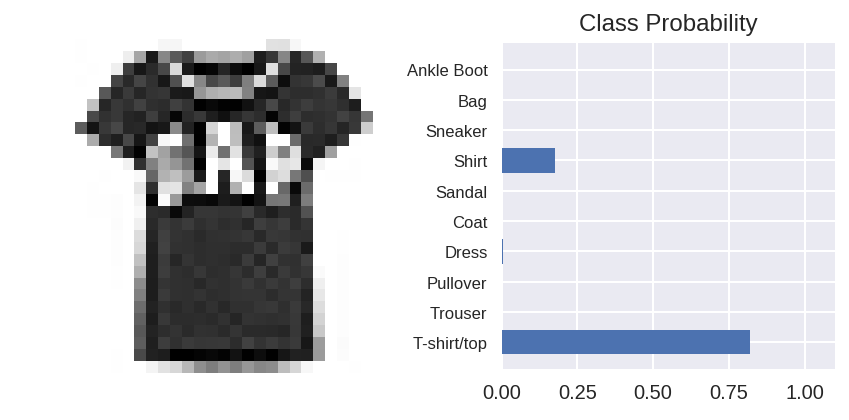

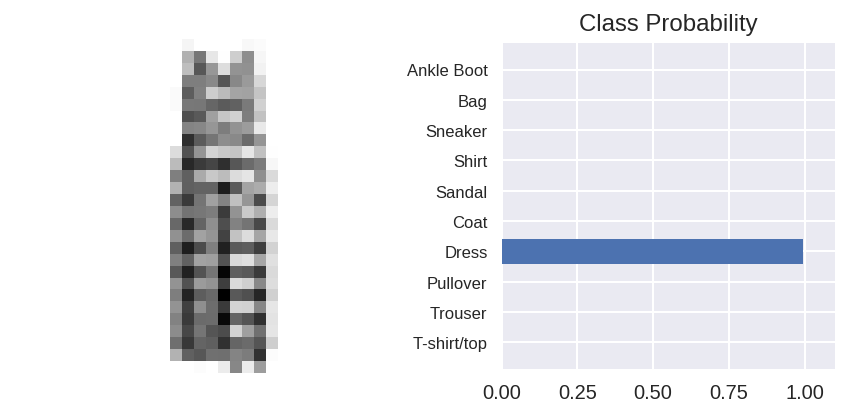

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Test out the network!
for i in range(10):
    dataiter = iter(test_loader)
    images, labels = dataiter.next()
    img = images[1]

    # TODO: Calculate the class probabilities (softmax) for img
    ps = torch.exp(model(img.to(device)))

    # Plot the image and probabilities
    view_classify(img, ps.cpu(), version='Fashion')

# MNIST

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)
1642934.0
0: Training loss: 0.16010524469738205
0: Training accuracy: 0.9699999690055847
1: Training loss: 0.05293328202717627
1: Training accuracy: 0.9799999594688416
2: Training loss: 0.04093100424700727
2: Training accuracy: 0.9899999499320984


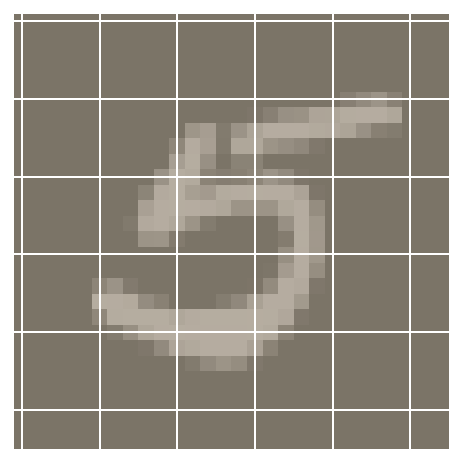

In [10]:

# Tune hyperparameters here

num_epochs = 3
batch_size = 100
learning_rate = 0.005
log_freq=25

# Load the MNIST dataset (images and labels, both train and test) into 2 DataLoaders
train_dataset = torchvision.datasets.MNIST(root='./data_mnist', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data_mnist', 
                                          train=False, 
                                          transform=transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True);

image, label = next(iter(test_loader))
imshow(image[0,:]);
    
class Net(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
net = Net()
print(net)
      

optimizer = optim.Adam(net.parameters(), lr=learning_rate)

log_dir = f'./logs/MNIST_control_run_lr_{learning_rate}'
criterion = nn.NLLLoss().to(device)
    
net = train_model(net,
                log_dir,
                train_loader,
                criterion,
                optimizer,
                num_epochs, log_freq)

# final_acc, final_loss = test_model(net, criterion, test_loader)
# print(f'Average accuracy of the network on test images: {final_acc}')
# print(f'Avg. Loss of the network on test images: {final_loss}')

# final_acc, final_loss = test_model(net, criterion, train_loader)
# print(f'Average accuracy of the network on train images: {final_acc}')
# print(f'Avg. Loss of the network on train images: {final_loss}')

In [17]:
final_acc, final_loss = test_model(net, criterion, test_loader)
print(f'Average accuracy of the network on test images: {final_acc}')
print(f'Avg. Loss of the network on test images: {final_loss}')

Average accuracy of the network on test images: 0.9799999594688416
Avg. Loss of the network on test images: 0.050348411980475065


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# visualize results
with torch.no_grad():
    for  images, labels in test_loader:
        images, labels = images.to(device), labels.long().to(device)
        output = ps = torch.exp(net(images))
        for i,ps in enumerate(output):
            img = images[i]
#             ps = output[i]

            # Plot the image and probabilities
            view_classify(img.cpu(), ps.cpu(), version='MNIST')

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


#CIFAR 

In [0]:
num_epochs = 8
batch_size = 250
learning_rate = 0.0028
log_freq=25



# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Load the CIFAR dataset (images and labels, both train and test) into 2 DataLoaders
train_dataset = torchvision.datasets.CIFAR10(root='./data_cifar', 
                                           train=True, 
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data_cifar', 
                                          train=False, 
                                          transform=transform)




train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True);

# image, label = next(iter(test_loader))
# imshow(image[0,:]);


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU())
        self.fc4 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU())
        self.fc5 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU())
        self.fc6 = nn.Sequential(
            nn.Linear(64, 10),
            nn.ReLU())
        self.softmax = F.log_softmax

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        out = self.softmax(self.fc6(out), dim=1)
        return out
    
net = Net()
print(net)
      
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

log_dir = f'./logs/CIFAR_Net_CONTROL_GROUP_lr_{learning_rate}'
criterion = nn.NLLLoss().to(device)
    
net = train_model(net,
                log_dir,
                train_loader,
                criterion,
                optimizer,
                num_epochs, log_freq)

final_acc, final_loss = test_model(net, criterion, test_loader)
print(f'Average accuracy of the network on test images: {final_acc}')
print(f'Avg. Loss of the network on test images: {final_loss}')

final_acc, final_loss = test_model(net, criterion, train_loader)
print(f'Average accuracy of the network on train images: {final_acc}')
print(f'Avg. Loss of the network on train images: {final_loss}')